In [1]:
import diracpy as dp
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
cav = dp.fock_subspace(index = 0)
atom = dp.two_level_subspace(index = 1)

In [3]:
delta_c = 2127293674469188.0
delta_a = 2127293674469188.0
g = 60112183589120.08
kappa =123179248988002.58

In [4]:
def error_tol(f1, f2, tol):
    return abs(f1 - f2) < tol

In [5]:
ham = delta_c * cav.n +  delta_a * atom.sigma_z
ham_int = g * (cav.a * atom.sigma_plus +  cav.adag * atom.sigma_minus)
initialbasis = [(1,'g'),(0,'e')]

In [6]:
testsys_unievo = dp.qsys(ham + ham_int,initialstates = initialbasis, n_int = 0)
psi0_unievo = dp.ket((0,'e'))
rho0_op_unievo = psi0_unievo * psi0_unievo.conj()
rho0_unievo = testsys_unievo.matrix(rho0_op_unievo)
T = 1e-12
times = np.linspace(0, T, 500)
soln_unievo = dp.unitaryevolution(rho0_unievo, times, testsys_unievo)
soln_unievo.solve()
cav_pop_unievo= np.real(soln_unievo.soln[:,0,0])
atom_pop_unievo = np.real(soln_unievo.soln[:,1,1])
print(cav_pop_unievo[-1])
print(error_tol(cav_pop_unievo[-1],0.16770312820379182,tol=1e-8))

building sys basis...
...system basis built in 8.726119995117188e-05 seconds
defining hmatrix...
...hmatrix evaluated in 0.0011212825775146484 seconds
0.16770312820379182
True


In [7]:
testsys_lindint = dp.qsys(ham + ham_int,initialstates = initialbasis, n_int = 0, jump_ops = [np.sqrt(kappa) * cav.a])
psi0_lindint = dp.ket((0,'e'))
rho0_op_lindint = psi0_lindint * psi0_lindint.conj()
rho0_lindint = testsys_lindint.matrix(rho0_op_lindint)
T = 1e-12
times = np.linspace(0, T, 500)
soln_lindint = dp.lindbladint(rho0_lindint, times, testsys_lindint)
soln_lindint.solve()
cav_pop_lindint= np.real(soln_lindint.soln[:,0,0])
atom_pop_lindint = np.real(soln_lindint.soln[:,1,1])
print(error_tol(cav_pop_lindint[-1],1.0402581147105376e-13,tol=1e-8))
print(cav_pop_lindint[-1])

building sys basis...
...appending decay subspaces...
...appending decay subspaces...
...system basis built in 0.0006949901580810547 seconds
defining hmatrix...
...hmatrix evaluated in 0.0008218288421630859 seconds
True
1.0402581147105376e-13


In [8]:
testsys_vnint = dp.qsys(ham + ham_int,initialstates = initialbasis, n_int = 0, jump_ops = [np.sqrt(kappa) * cav.a])
psi0_vnint = dp.ket((0,'e'))
rho0_op_vnint = psi0_vnint * psi0_vnint.conj()
rho0_vnint = testsys_vnint.matrix(rho0_op_vnint)
T = 1e-12
times = np.linspace(0, T, 500)
solver_vnint = dp.vonneumannint(rho0_vnint, times, testsys_vnint)
#soln.solve()
cav_pop_vnint= np.real(solver_vnint.soln[:,0,0])
atom_pop_vnint = np.real(solver_vnint.soln[:,1,1])
print(error_tol(cav_pop_vnint[-1],0.167700032724725,tol=1e-8))
print(cav_pop_vnint[-1])

building sys basis...
...appending decay subspaces...
...appending decay subspaces...
...system basis built in 0.0005211830139160156 seconds
defining hmatrix...
...hmatrix evaluated in 0.000850677490234375 seconds
True
0.167700032724725


In [9]:
class liouville:

    # z0 is the initial state of the system described by its density matrix.
    # z0 is represented by a 2d complex numpy array with the dimensions of the Hamiltonian
    # times is linearly spaced numpy array of times for which the system is solved for
    # This class is used to solve the dynamics for an open quantum system using the Liouvillian.
    # Note; to quickly access the steady state times can be a array of shape (2,) with a large final time 
    # as the evolution is 

    
    def __init__(self, z0, times, ham_obj):
        self.t = times
        self.z = z0 
        self.ham = ham_obj
        self.dim = self.ham.dim
        self.identity = np.identity(self.dim)
        self.flsize = self.dim**2
        self.vz = z0.T.reshape(z0.size)
        self.liouvillian = self.generate_liouvillian()
        
    def lindblad_sop(self):
        '''converts dissipative part of master equation into superoperator'''
        lindbladsop = np.zeros((self.ham.hmatrix.size, self.ham.hmatrix.size), complex)
        for i in self.ham.lindbladgamma:
            gamma = self.ham.lindbladgamma[i]
            lbr = self.ham.lindbladraising[i]
            lbl = self.ham.lindbladlowering[i]
            lindbladsop += gamma*(np.kron(lbl.conj(), lbl) - 0.5*np.kron(self.identity, lbr@lbl) - 0.5*np.kron((lbr@lbl).T, self.identity))
        return lindbladsop
    
    def system_sop(self):
        '''converts unitary part of master equation into superoperator'''
        return -1j*(np.kron(self.identity, self.ham.hmatrix) - np.kron(self.ham.hmatrix.T, self.identity))
        
    def generate_liouvillian(self):
        '''returns the liouvillian superoperator'''
        return self.system_sop() + self.lindblad_sop()
    
    def eigensolve(self):
        '''returns liouvillian eigenvalues and eigevectors'''
        self.evals, self.levecs, self.revecs = scipy.linalg.eig(self.liouvillian, right = True, left = True)
              
    def expL_op(self, t):
        L = np.zeros([self.dim**2, self.dim**2], complex)
        for i in range(self.dim**2):
            L[i,i] = np.exp(self.evals[i]*t)
        L = self.revecs @ L @ np.linalg.inv(self.revecs)
        return L
    
    def solve(self):
        '''calculates time evolution of z0 using liouvillian'''
        self.eigensolve()
        dt = self.t[1] - self.t[0]
        num_t = np.size(self.t)
        self.soln = np.zeros([num_t, self.dim, self.dim], complex)
        if np.linalg.det(self.revecs) == 0:
            print('The Liouvillian does not have linearly independent right eigenvectors: L is not diagonalisable')
        else: 
            for i, t in enumerate(self.t):
                self.soln[i] = self.vz.reshape((self.dim, self.dim)).T
                self.vz = self.expL_op(dt)@self.vz     
    
    

In [13]:

testsys_lv = dp.qsys(ham + ham_int,initialstates = initialbasis, n_int = 0, jump_ops = [np.sqrt(kappa) * cav.a])
psi0_lv = dp.ket((0,'e'))
rho0_op_lv = psi0_lv * psi0_lv.conj()
rho0_lv = testsys_lv.matrix(rho0_op_lv)
T = 1e-12
times = np.linspace(0, T, 500)
solver_lv = liouville(rho0_lv, times, testsys_lv)
solver_lv.solve()
cav_pop_lv= np.real(solver_lv.soln[:,0,0])
atom_pop_lv = np.real(solver_lv.soln[:,1,1])
print(error_tol(cav_pop_lv[-1],2.315584825739848e-27,tol=1e-8))
print(cav_pop_lv[-1])

building sys basis...
...appending decay subspaces...
...appending decay subspaces...
...system basis built in 0.00044536590576171875 seconds
defining hmatrix...
...hmatrix evaluated in 0.0007398128509521484 seconds
True
2.315584825739848e-27


In [14]:
testsys_sint = dp.qsys(ham + ham_int,initialstates = initialbasis, n_int = 0)
psi0_sint = np.array([0,1])
T = 1e-12
times = np.linspace(0, T, 500)
soln_sint = dp.schrodint(psi0_sint, times, testsys_sint)
soln_sint.solve()
cav_pop_sint= abs(soln_sint.soln[:,0])**2
atom_pop_sint = abs(soln_sint.soln[:,1])**2
print(cav_pop_sint[-1] == 0.1677069988800502)
print(cav_pop_sint[-1])

building sys basis...
...system basis built in 3.62396240234375e-05 seconds
defining hmatrix...
...hmatrix evaluated in 0.0006690025329589844 seconds
True
0.1677069988800502


building sys basis...
...appending decay subspaces...
...appending decay subspaces...
...system basis built in 0.0004706382751464844 seconds
defining hmatrix...
...hmatrix evaluated in 0.0007309913635253906 seconds


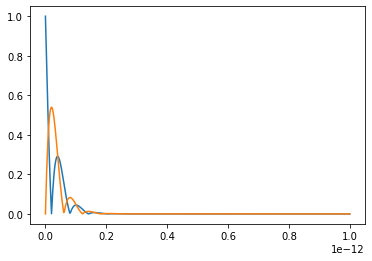

In [15]:
testsys_qj = dp.qsys(ham + ham_int,initialstates = initialbasis, n_int = 0,jump_ops = [np.sqrt(kappa) * cav.a] )
psi0_qj = np.array([1,0,0])
T = 1e-12
times = np.linspace(0, T, 500)
soln_qj = dp.quantumjumps(psi0_qj, times, testsys_qj)
#soln.generate_nonhermitian_ham()
soln_qj.solve()
cav_pop_qj= np.abs(soln_qj.soln[:,0])
atom_pop_qj = np.abs(soln_qj.soln[:,1])
plt.plot(times, cav_pop_qj, label = r'$\left|0,e,g\right\rangle$')
plt.plot(times, atom_pop_qj, label = r'$\left|0,g,e\right\rangle$')
plt.show()